# Experiments

In [3]:
# !pip2 install pypolyagamma

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import plotnine as gg

#import importlib
#importlib.reload(logistic.agent_logistic)
#reload(sys.modules['logistic.agent_logistic'])

# Setup

Here $d=20$ and the number of arms is $A=100$. The number of timesteps is $T=1000$.

At the beginning $\theta\sim N(0,I_d)$ is generated. The reward given context $x\in \mathbb R^d$ is $\text{Bernoulli}(\sigma(\theta^\top x))$ where $\sigma(x) = \frac{e^x}{1+e^x}$. At each step $x_{t,1},\ldots, x_{t,A}\sim N(0,I_d/9)$ are randomly generated, and the algorithm picks one of the arms $1,\ldots, A$ and gets the corresponding stochastic reward.

If the algorithm chose actions $a_t$, regret is measured as $\max_{\{a_t^*\}} \sigma(\theta^\top x_{t,a_t^*}) - \sum_{t=1}^T \mathbb E \sigma(\theta^\top x_{t,a_t})$, i.e., expected reward against the best choice of $a_t^*$'s if $\theta$ were known.


In [4]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    print('SEED: %d' % seed)
    env = LogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        print(cum_regrets)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, df_list, cum_regrets_list, avg_regrets    

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seed=0, verbosity=0):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
    
def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets


In [5]:
num_articles = 100
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 1

verbosity=0

In [6]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda hypers: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda hypers: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = hypers[1],
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda hypers: SAGATS(num_articles, dim, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = hypers[1],
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=99999, time = time_limit, verbosity=verbosity)

In [7]:
make_best_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_best_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)

make_best_langevin_agent = lambda: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)

In [8]:
import warnings
warnings.filterwarnings('ignore')

SEED: 1000
theta [-0.8044583   0.32093155 -0.02548288  0.64432383 -0.30079667  0.38947455
 -0.1074373  -0.47998308  0.5950355  -0.46466753  0.66728131 -0.80611561
 -1.19606983 -0.40596016 -0.18237734  0.10319289 -0.13842199  0.70569237
  1.27179528 -0.98674733]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experiment: Step 33
Experiment: Step 34
Experiment: Step 35
Experiment: Step 36
Experime

Experiment: Step 383
Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: Step 426
Experiment: Step 427
Experiment: Step 428
Experiment: Step 429
Experiment: S

Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: Step 817
Experiment: Step 818
Experiment: Step 819
Experiment: Step 820
Experiment: S

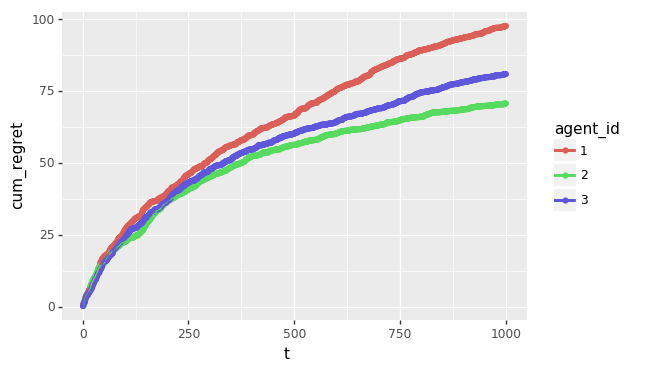

<ggplot: (8727538080165)>


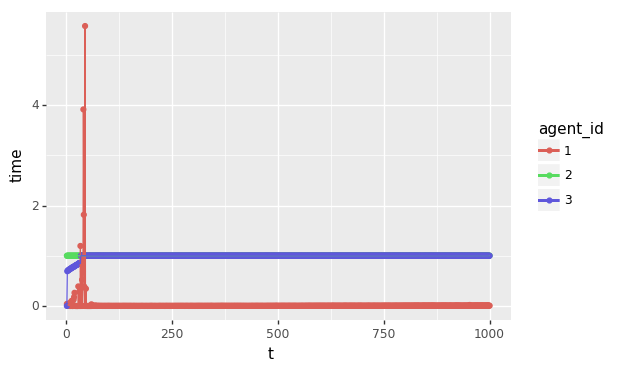

<ggplot: (8727638655701)>
[97.70589718759197, 70.71833591904773, 80.974701034082]
SEED: 1001
theta [-1.08644637 -0.89606513 -0.30629937 -1.33993366 -1.20658558 -0.64172681
  1.30794563  1.84546043  0.82911495 -0.02329881 -0.20856395 -0.91661975
 -1.07474258 -0.08614349  1.17583854 -1.63509173  1.228194    1.07638625
  0.39477287 -0.38770082]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experi

Experiment: Step 379
Experiment: Step 380
Experiment: Step 381
Experiment: Step 382
Experiment: Step 383
Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: S

Experiment: Step 770
Experiment: Step 771
Experiment: Step 772
Experiment: Step 773
Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: S

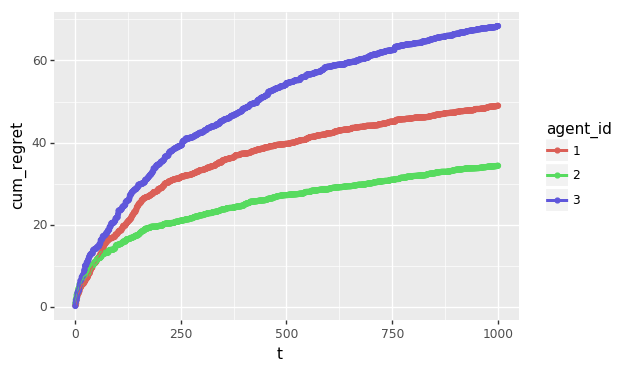

<ggplot: (8727538016905)>


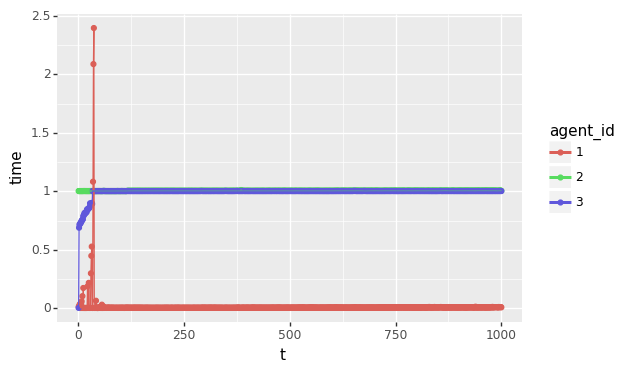

<ggplot: (8727638644013)>
[48.9816397335897, 34.362242611399346, 68.38177169562087]
SEED: 1002
theta [-0.11271303 -1.07656398  1.78502693 -1.45698331 -0.32632079 -1.25989648
  0.3758665  -0.87814737 -0.34997577  0.2966602   1.20091193 -1.56899524
  1.85402874  0.49396181 -0.13071143 -0.40312075 -0.97366226 -0.46746678
 -0.71792147  1.22139331]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Expe

Experiment: Step 379
Experiment: Step 380
Experiment: Step 381
Experiment: Step 382
Experiment: Step 383
Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: S

Experiment: Step 770
Experiment: Step 771
Experiment: Step 772
Experiment: Step 773
Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: S

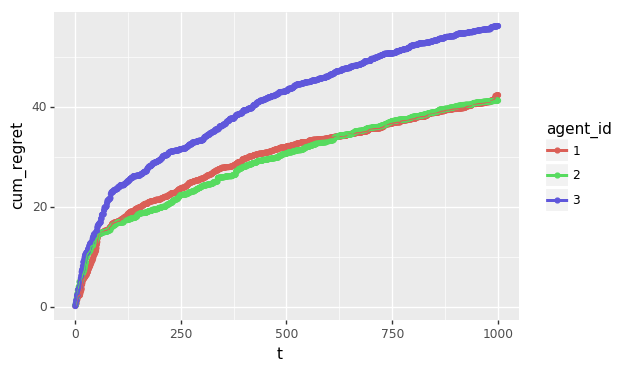

<ggplot: (8727638575301)>


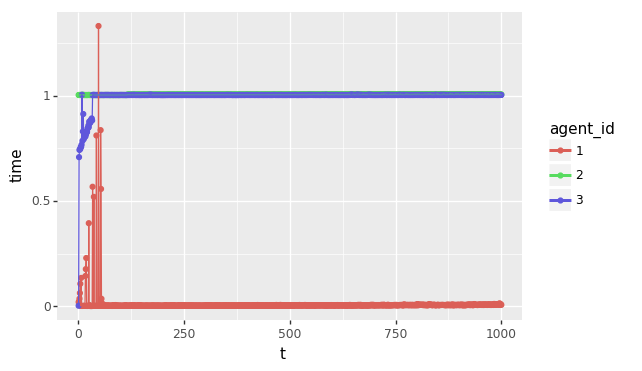

<ggplot: (8727638386641)>
[42.34050905891085, 41.25142923651612, 56.1516031590906]
SEED: 1003
theta [-1.32104352  2.01675288  0.04756447 -0.23767117  0.08412267  0.95954226
 -0.68159849  0.5290704  -0.77491822  1.4049562  -0.22468048 -1.30588569
 -0.67853522 -1.62093328 -1.27997353 -0.2242967  -0.85056104 -0.7557401
  0.2631708  -2.55519304]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experi

Experiment: Step 379
Experiment: Step 380
Experiment: Step 381
Experiment: Step 382
Experiment: Step 383
Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: S

Experiment: Step 770
Experiment: Step 771
Experiment: Step 772
Experiment: Step 773
Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: S

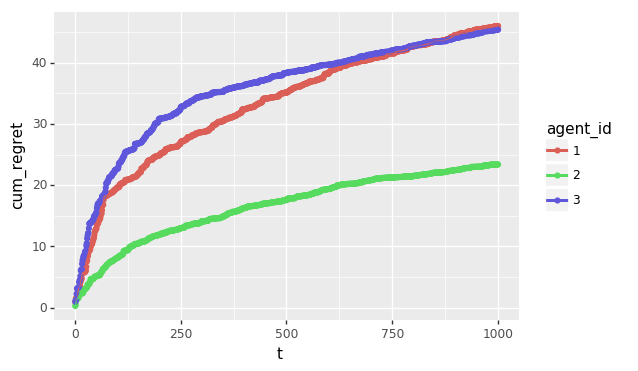

<ggplot: (8727638321961)>


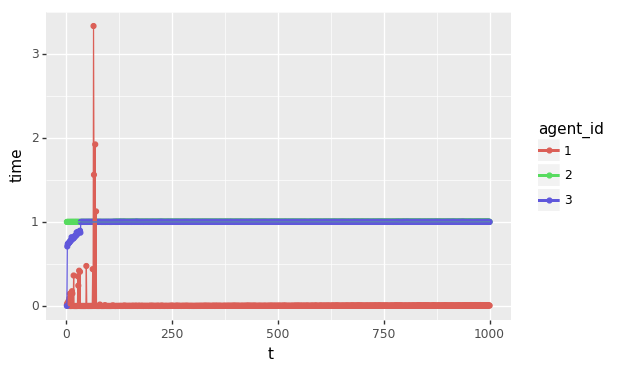

<ggplot: (8727638398933)>
[46.029750242093805, 23.39281282871139, 45.43533208914763]
SEED: 1004
theta [ 0.59440307  0.40260871 -0.80516223  0.1151257  -0.75306522 -0.7841178
  1.46157577  1.57607553 -0.17131776 -0.91448182  0.86013945  0.35880192
  1.72965706 -0.49764822  1.7618699   0.16901308 -1.08523701 -0.01065175
  1.11579838 -1.26497153]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Expe

Experiment: Step 379
Experiment: Step 380
Experiment: Step 381
Experiment: Step 382
Experiment: Step 383
Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: S

Experiment: Step 770
Experiment: Step 771
Experiment: Step 772
Experiment: Step 773
Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: S

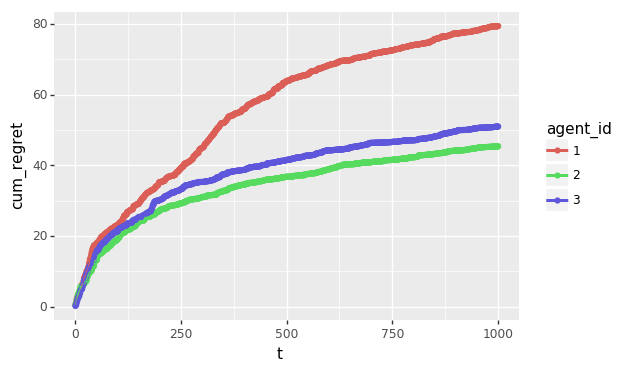

<ggplot: (8727638188433)>


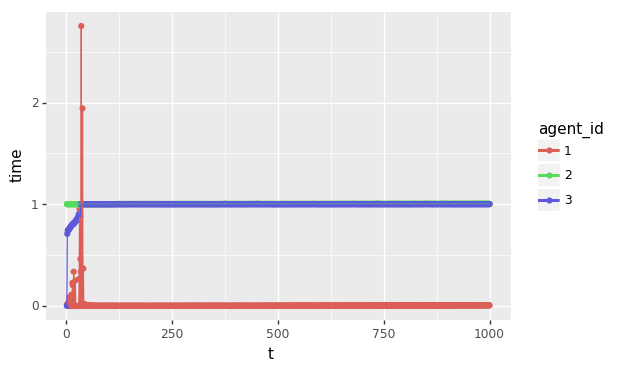

<ggplot: (8727638356173)>
[79.45911017586678, 45.38404302239415, 50.97982808691318]


([[      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
   0             1        1     0.936289    0.270341        0.270341     1   
   1             2        2     0.936289    0.296448        0.296448     1   
   2             3        3     0.936289    0.280256        0.280256     1   
   3             4        1     1.839505    0.988617        0.718275     2   
   4             5        2     1.839505    0.364479        0.068031     2   
   5             6        3     1.839505    0.992018        0.711761     2   
   6             7        1     2.791038    1.506229        0.517613     3   
   7             8        2     2.791038    0.891583        0.527104     3   
   8             9        3     2.791038    1.023944        0.031926     3   
   9            10        1     3.661451    1.647371        0.141142     4   
   10           11        2     3.661451    1.295534        0.403950     4   
   11           12        3     3.661451    1.455720        0.43

In [10]:
#https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
make_agents = [make_laplace_agent,
               #make_pgts_agent,
               #make_best_langevin_agent,
               make_mala_agent,
               #make_best_sgld_agent,
               make_best_sagald_agent]
                #,make_mala_agent_untimed]
simple_compares(make_agents, num_articles, dim, var, 1000, range(1000,1005), verbosity=1)
#simple_compares(make_agents, num_articles, dim, var, 1000, range(100,105), verbosity=verbosity)

In [ ]:
"""
[[97.70589718759197, 70.71833591904773, 80.974701034082],
  [48.9816397335897, 34.362242611399346, 68.38177169562087],
  [42.34050905891085, 41.25142923651612, 56.1516031590906],
  [46.029750242093805, 23.39281282871139, 45.43533208914763],
  [79.45911017586678, 45.38404302239415, 50.97982808691318]],
 array([62.90338128, 43.02177272, 60.38464721]))
"""

In [17]:
make_sagald_agent2 = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=0)
make_prec_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          precondition='proper',
                                          init_pt=None, verbosity=0)

SEED: 1000
theta [-0.8044583   0.32093155 -0.02548288  0.64432383 -0.30079667  0.38947455
 -0.1074373  -0.47998308  0.5950355  -0.46466753  0.66728131 -0.80611561
 -1.19606983 -0.40596016 -0.18237734  0.10319289 -0.13842199  0.70569237
  1.27179528 -0.98674733]
Experiment: Step 0
 Sample: array([-1.51148464, -0.05564846, -0.35246522, -0.42023391,  1.3668683 ,
       -0.89246326, -1.34551226, -1.22933195, -0.30967447, -1.63257432,
       -2.86743882,  0.90417055, -0.97432004,  0.10809732,  0.7434614 ,
        1.03885914,  0.3654813 , -0.67734059, -0.07023414,  1.28264017])
 Steps taken: 0
 Sample: array([-1.31080286,  0.09925165, -0.2669887 ,  1.65950663, -0.35241517,
       -0.04915007,  0.9889304 , -0.22114292, -0.49216754,  0.17707282,
       -0.1739487 , -0.2387779 ,  0.17607671, -1.29062463, -0.30779354,
       -0.10880146, -2.21143023, -1.6572282 , -1.67729748,  1.2663155 ])
 Steps taken: 0
Experiment: Step 1
 Sample: array([ 0.4331253 , -1.42733876, -1.0812354 , -0.28579551,  0.5

 Sample: array([-0.37843356,  0.97227292, -0.64504368, -0.50908939,  0.73856561,
        0.28525347, -0.30639919,  0.07759497, -0.7094575 ,  0.21961299,
        1.4018655 , -1.51945321, -0.05194932,  1.53824368,  0.60528664,
       -1.09915897,  1.49019491,  0.58524168,  0.08796779, -0.72566082])
 Steps taken: 1409
Experiment: Step 13
 Sample: array([-0.16254961,  1.9264792 ,  0.26547462, -0.17836874,  0.10304811,
       -0.75396992,  0.69483713, -0.80559278, -1.18842047, -1.46353724,
       -0.61981132, -1.20717937, -1.73830005, -0.78676969, -0.1386715 ,
        0.21487667,  0.09541166, -1.22229268,  1.75365327, -1.22906157])
 Steps taken: 9999
 Sample: array([-0.79567457,  0.11903928,  0.12549053,  1.25403581,  0.91458255,
        0.27346068, -0.87151553,  1.14829968, -0.54389688, -1.08020818,
        0.13892783,  0.29824171,  0.59542088, -0.68422599,  1.7633581 ,
       -0.90591541,  1.64243218, -0.94005422,  0.36189835,  0.92889967])
 Steps taken: 1898
Experiment: Step 14
 Sample: 

 Sample: array([-2.91112174,  2.11607715,  0.96719022,  1.24577188, -1.15950762,
       -0.89554366, -0.35995211,  1.22293236, -0.87878635,  0.8102034 ,
        0.41967422, -1.63573515,  0.31283309,  0.51385677, -0.50822612,
        0.46724601,  0.29739557, -0.54752167,  0.1931782 , -0.29886158])
 Steps taken: 9999
 Sample: array([-1.65039236,  0.2208995 ,  0.77739021, -2.01019176,  0.12536869,
        0.03932751, -1.26593623, -0.05001242, -0.59976992, -0.27877197,
        0.04869541,  1.02146925,  0.52881004, -0.46626435,  0.08474479,
        1.40671557, -0.99889408,  0.67391394,  1.67343579, -0.81707838])
 Steps taken: 1868
Experiment: Step 26
 Sample: array([-0.43466793,  1.38707508,  0.26317853,  0.40166408, -0.07683344,
       -0.62267442,  0.07703218,  1.47264643, -2.62289934,  0.35778463,
        0.09803655, -0.69074047, -0.6333211 , -1.50311501,  0.08809395,
        0.01394503,  0.35456352, -2.05607112, -0.01930805, -0.20347198])
 Steps taken: 9999
 Sample: array([-1.64978442, 

 Sample: array([-2.34568368, -0.11811894, -0.09235379,  0.35412265, -0.08639431,
        0.23096116, -0.68499806,  0.79247956,  0.77367899, -0.23306161,
        0.5826837 , -0.77646428,  0.09289085, -0.5199711 , -0.37235085,
        0.31465738,  0.02461005,  0.14380618,  0.09423645,  0.98567242])
 Steps taken: 8741
 Sample: array([-0.33890759, -1.25464148, -0.11333968,  0.41771202,  0.47857535,
        0.21772463,  0.10514895, -0.36499998,  1.29020733, -0.86174851,
        0.29347868,  1.355261  , -0.22831473,  0.95145705, -1.01995088,
       -0.49430024,  0.94773076,  0.16773283,  0.29391032, -0.53801947])
 Steps taken: 1797
Experiment: Step 39
 Sample: array([-2.26527262,  1.52196909,  0.00311042, -0.1937184 ,  0.43238053,
        0.6998367 , -0.07285023,  0.20869028, -1.7140247 ,  0.97348713,
       -0.15165347,  1.33776511, -0.45014338, -0.68413867, -0.54979951,
        1.09002729,  0.02083366, -0.85063406, -0.1569104 ,  1.19056436])
 Steps taken: 8766
 Sample: array([-0.24625784, 

 Sample: array([-9.20812265e-01, -2.46894126e-01, -5.15027825e-01,  5.46366222e-01,
        3.77118901e-01, -1.44918466e-01, -2.51278919e-02, -8.01357234e-01,
        7.41455617e-04, -1.35045658e+00, -8.74593717e-01,  4.86398255e-01,
       -1.62448577e-01, -7.83245136e-01, -4.79847852e-01, -1.51201435e-01,
        9.84055044e-01,  3.09565089e-01,  6.39141338e-01,  4.72990058e-01])
 Steps taken: 1829
Experiment: Step 51
 Sample: array([-1.04664333,  1.44407826, -0.08579337,  3.10215917, -1.05668095,
        1.10100411,  0.23327471, -0.71472008, -1.59135248,  0.74439335,
        0.06723507,  0.22241265, -0.84829405, -0.21575899,  0.97332926,
        0.32014701,  0.1282708 ,  0.89852765, -0.23863071, -0.14197727])
 Steps taken: 8719
 Sample: array([-0.47861212, -0.02839579, -0.33725467,  0.28044262,  0.55892226,
        0.3304908 ,  0.11987325, -1.30723247, -0.86043315, -1.06843749,
       -0.52697976,  0.63401188, -0.34887901, -1.40890888, -0.48763792,
       -0.2761155 ,  1.08950916,  

 Sample: array([-2.48117091,  0.90184776,  0.50164961,  2.26862912, -1.10743395,
       -0.36904581, -1.65633344, -0.25099306, -0.63263254,  1.3643452 ,
        1.83437203, -0.37942265, -0.42342403,  0.04831046, -0.55436295,
        1.09138154,  0.87682555, -0.14893161, -0.56165815,  0.57468992])
 Steps taken: 8644
 Sample: array([-0.73808912, -1.00035522, -0.9434381 ,  1.00485791,  0.54637402,
        1.30471419,  0.02290406, -0.98993527,  0.10929841, -0.98503213,
        1.52650489,  1.5796607 ,  0.66156202, -0.34954419, -0.47357367,
       -0.86113619,  0.34343274, -0.50571604,  0.50981283,  0.2317472 ])
 Steps taken: 1791
Experiment: Step 64
 Sample: array([-1.61644054, -0.09433808, -0.09053079,  0.30650175, -0.49375759,
       -0.25829256, -0.65106411,  0.93735967, -0.06628769, -0.77001795,
       -0.43076425, -0.21124374, -0.44679548, -1.0085553 ,  0.38819603,
        0.33186423, -1.14053934,  0.04081274, -0.36720266, -0.09344654])
 Steps taken: 8738
 Sample: array([-0.6781752 , 

 Sample: array([-0.73323741,  0.22181697,  0.23922679,  0.30874029, -0.55426465,
       -1.4226019 , -0.77752384,  0.50545692,  0.33706389, -0.11896693,
       -0.20119171, -1.31556832,  0.2644674 , -0.06211192,  0.94246544,
       -0.03532467,  0.14058608,  0.37192614,  1.24325313,  0.38901384])
 Steps taken: 8657
 Sample: array([-0.23498201, -1.15242685,  0.09584359,  1.63902526,  0.4574754 ,
        0.72564133, -0.86759684, -1.54360403, -0.76965732, -0.9296732 ,
       -0.32097723,  0.81699135,  0.80092199,  0.52163793, -0.55408147,
       -0.46054654, -0.33614283,  0.42991326, -0.0376037 , -0.31335681])
 Steps taken: 1740
Experiment: Step 77
 Sample: array([-0.57400835,  1.09213467,  0.30924822,  0.66355755,  0.44479756,
       -0.08291939,  0.70347744,  1.05102662,  0.79616424,  0.93432512,
        0.89417352, -0.38691402,  0.7965144 , -0.29599497, -0.44545947,
        0.47575436,  0.4880493 ,  0.04656847,  0.53270124, -0.92469605])
 Steps taken: 8709
 Sample: array([-0.3776712 , 

 Sample: array([-1.18211009, -0.2883601 , -0.52214781,  0.49498919, -0.04824227,
        0.99453766, -0.25420291, -1.2419371 , -0.14558465, -0.58126873,
        0.0170516 ,  0.33628967, -0.58824811,  0.56621498, -1.51434683,
        0.20637577,  0.38438848,  0.91420039,  0.61816218, -1.06880091])
 Steps taken: 1797
Experiment: Step 89
 Sample: array([-1.65901719,  1.80434042, -0.565521  ,  1.39859961, -0.48123163,
        1.26957741, -1.03012085,  0.58103661,  0.12504896,  0.75717687,
        1.66443412,  0.16120066,  0.25250817, -1.55297004, -0.76967029,
        0.1725999 ,  0.06095988,  0.4311665 , -0.25788368,  0.28923534])
 Steps taken: 8578
 Sample: array([-0.8781442 , -0.42510475, -0.62926551,  0.71014733, -0.17264778,
        0.96287063, -0.12183264, -1.27666401, -0.48241441, -0.75197953,
        0.00835794,  0.31534958, -0.02185541,  0.01504109, -1.74865085,
        0.62303447,  0.60265628,  1.13350875,  0.7041752 , -1.07781139])
 Steps taken: 1786
Experiment: Step 90
 Sample: 

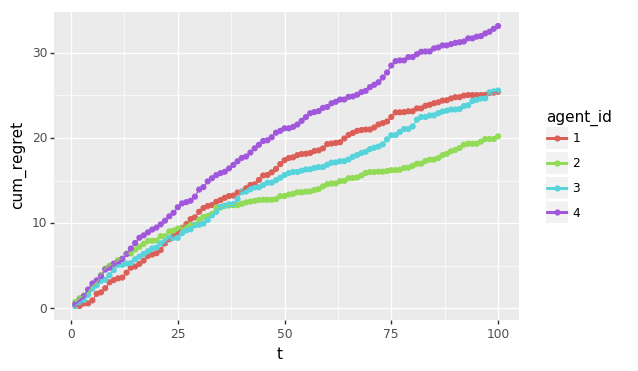

<ggplot: (8727638621073)>


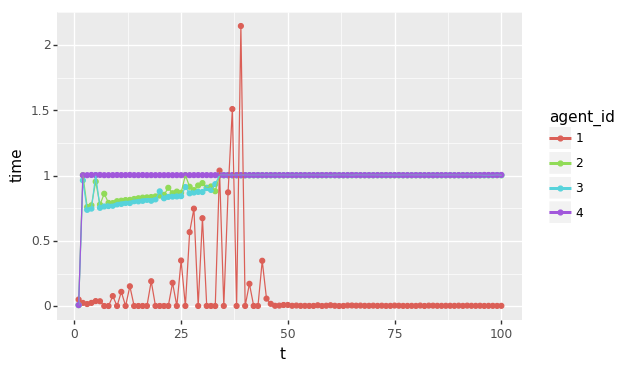

<ggplot: (8727582112041)>
[25.423021096974875, 20.19266019620516, 25.57230748291844, 33.14476456409398]


([[     action_id agent_id  cum_optimal  cum_regret  instant_regret    t  \
   0            1        1     0.936289    0.270341        0.270341    1   
   1            2        2     0.936289    0.743414        0.743414    1   
   2            3        3     0.936289    0.280256        0.280256    1   
   3            4        4     0.936289    0.488910        0.488910    1   
   4            5        1     1.855006    0.275952        0.005611    2   
   5            6        2     1.855006    1.191251        0.447836    2   
   6            7        3     1.855006    0.704554        0.424297    2   
   7            8        4     1.855006    0.933144        0.444234    2   
   8            9        1     2.781057    0.574316        0.298364    3   
   9           10        2     2.781057    1.482127        0.290877    3   
   10          11        3     2.781057    0.916763        0.212209    3   
   11          12        4     2.781057    1.433565        0.500421    3   
   12       

In [15]:
make_agents2 = [make_laplace_agent,
               make_best_sagald_agent,
               make_sagald_agent2,
               make_prec_sagald_agent
               ]
                #,make_mala_agent_untimed]
simple_compares(make_agents2, num_articles, dim, var, 100, [1000], verbosity=1)
#simple_compares(make_agents, num_articles, dim, var, 1000, range(100,105), verbosity=verbosity)

SEED: 1000
theta [-0.8044583   0.32093155 -0.02548288  0.64432383 -0.30079667  0.38947455
 -0.1074373  -0.47998308  0.5950355  -0.46466753  0.66728131 -0.80611561
 -1.19606983 -0.40596016 -0.18237734  0.10319289 -0.13842199  0.70569237
  1.27179528 -0.98674733]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experiment: Step 33
Experiment: Step 34
Experiment: Step 35
Experiment: Step 36
Experime

Experiment: Step 383
Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: Step 426
Experiment: Step 427
Experiment: Step 428
Experiment: Step 429
Experiment: S

Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: Step 817
Experiment: Step 818
Experiment: Step 819
Experiment: Step 820
Experiment: S

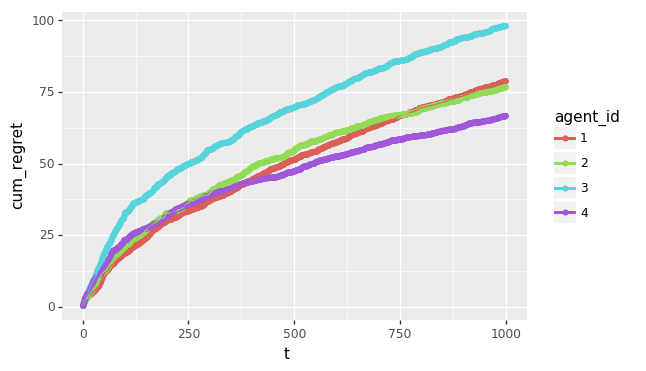

<ggplot: (8727582154049)>


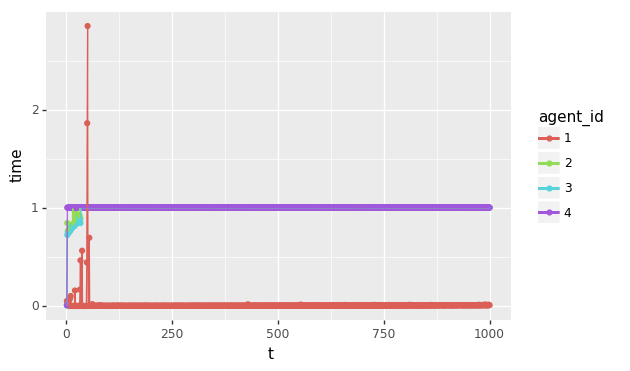

<ggplot: (8727581843453)>
[78.77118279076258, 76.75245877261091, 98.06075404998398, 66.64222319359605]


In [19]:
make_agents2 = [make_laplace_agent,
               make_best_sagald_agent,
               make_sagald_agent2,
               make_prec_sagald_agent
               ]
                #,make_mala_agent_untimed]
results_list, df_list, cum_regrets_list, avg_regrets  =simple_compares(make_agents2, num_articles, dim, var, 1000, [1000], verbosity=1)
#simple_compares(make_agents, num_articles, dim, var, 1000, range(100,105), verbosity=verbosity)

In [21]:
import pickle

pickle.dump((results_list, cum_regrets_list), open( "data-experiments10_1.p", "wb" ))